<a href="https://colab.research.google.com/github/CanopySimulations/canopy-python-examples/blob/master/fitting_aero_data_to_polynomial_and_rbf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upgrade Runtime
This cell ensures the runtime supports `asyncio` async/await, and is needed on Google Colab. If the runtime is upgraded, you will be prompted to restart it, which you should do before continuing execution.

In [0]:
!pip install "ipython>=7"

# Set Up Environment

### Import required libraries

In [0]:
!pip install -q 'canopy==8.9'

In [0]:
import canopy
import logging
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
import pandas as pd
import json
from typing import Sequence, Optional, NamedTuple, Any

logging.basicConfig(level=logging.INFO)
np.set_printoptions(suppress=True)

### Authenticate

In [0]:
authentication_data = canopy.prompt_for_authentication()

def create_session():
    return canopy.Session(authentication_data)

# Set Up Example

The `np.ndarray` type is not JSON serializable by default. This simple encoder converts `np.ndarray` to a Python array during serialization, allowing us to easily view the car component later.


In [0]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

# Example: Fitting Aero Data to a Polynomial and RBF.

Using a CSV of aero data containing the columns `hRidef`, `hRideR`, `aRollAbs`, `CLiftBodyF`, `CLiftBodyR` and `CDragBody` we will fit the data to a polynomial and then fit the residuals to an RBF.

We will then generate a Canopy component from the data and create a new car on the platform containing the result.

## Create Helper Functions

A simple helper function, `create_basis_position_indices`, which returns a random set indexes given the data length and maximum desired positions.

In [0]:
# Choose positions randomly among the data.
# This seems extremely simple, but tends to work very well.
def create_basis_position_indices(data_length: int, max_positions: int) -> Sequence[int]:
    n = min(max_positions, data_length)
    random_index_permutation = np.random.permutation(data_length)
    basis_position_indices = random_index_permutation[0:n]
    return basis_position_indices


The `fit_aero_data` function will do the fitting and return a `FittedAeroData` class containing the information we need to construct the car component.

In [0]:
class FittedAeroData(NamedTuple):
    polynomial_residuals: pd.DataFrame
    polynomial_rbf_residuals: pd.DataFrame
    polynomial_coefficients: np.ndarray
    rbf_basis_weights: np.ndarray
    input_offsets: np.ndarray 
    input_scales: np.ndarray
    input_length_scales: np.ndarray
    input_basis_positions: np.ndarray

#  Inputs might be something like ['hRideF, 'hRideR', 'aRollAbs']
#  Outputs might be something like ['CLiftBodyF', 'CLiftBodyR', 'CDragBody']
def fit_aero_data(
        data: pd.DataFrame,
        input_names: Sequence[str],
        output_names: Sequence[str],
        input_basis_position_indices: Optional[Sequence[int]] = None,
        input_length_scales_override: Optional[Sequence[float]] = None) -> FittedAeroData:

    data_length = len(data)
    input_count = len(input_names)
    inputs = data[input_names].to_numpy()
    outputs = data[output_names].to_numpy()

    # Scale all the input data so it ranges between +/- 1.
    inputs_max = inputs.max(0)
    inputs_min = inputs.min(0)

    input_offsets = -0.5 * (inputs_max + inputs_min)
    input_scales = 0.5 * (inputs_max - inputs_min)

    input_scaled = inputs + repmat(input_offsets, data_length, 1)
    input_scaled = input_scaled / repmat(input_scales, data_length, 1)

    # Now fit a simple polynomial. This consists of: 1. Cubic terms; 2.
    # Quadratic terms. 3. All linear cross terms. 4. All linear terms. 5. A
    # constant. It's not meant to be a perfect fit, just a passable one.
    polynomial = np.concatenate((
        inputs**3,
        inputs**2),
        axis=1)
    
    for i in range(0, input_count):
        for j in range(i+1, input_count):
            polynomial = np.concatenate((
                polynomial,
                (inputs[:,i] * inputs[:,j])[:, np.newaxis]),
                axis=1)

    polynomial = np.concatenate((
        polynomial,
        inputs, 
        (1+0*inputs[:, 0])[:, np.newaxis]),
        axis=1)
    
    polynomial_coefficients_result = np.linalg.lstsq(polynomial, outputs, rcond=None)
    polynomial_coefficients = polynomial_coefficients_result[0]

    ### print(polynomial_coefficients)

    polynomial_y = polynomial @ polynomial_coefficients

    # Compute the fit residuals: we're going to fit the RBF to these. 
    polynomial_residuals = outputs - polynomial_y

    if input_basis_position_indices is None:
        input_basis_position_indices = create_basis_position_indices(len(data), 150)
        #input_basis_position_indices = [69 ,42 ,138 ,160 ,77 ,151 ,101 ,10 ,110 ,120 ,129 ,6 ,66 ,43 ,82 ,125 ,115 ,102 ,28 ,34 ,52 ,156 ,144 ,60 ,133 ,145 ,53 ,126 ,32 ,75 ,108 ,51 ,159 ,40 ,93 ,63 ,104 ,97 ,155 ,11 ,137 ,103 ,83 ,88 ,141 ,148 ,165 ,80 ,9 ,19 ,113 ,20 ,3 ,17 ,147 ,98 ,72 ,8 ,99 ,170 ,90 ,114 ,166 ,44 ,81 ,47 ,38 ,161 ,46 ,26 ,65 ,1 ,78 ,143 ,37 ,45 ,41 ,39 ,54 ,171 ,84 ,168 ,24 ,169 ,58 ,12 ,22 ,134 ,68 ,172 ,89 ,94 ,92 ,35 ,116 ,135 ,124 ,18 ,95 ,91 ,136 ,49 ,142 ,131 ,86 ,74 ,107 ,100 ,112 ,23 ,50 ,117 ,15 ,5 ,64 ,130 ,122 ,128 ,164 ,118 ,109 ,25 ,158 ,27 ,152 ,29 ,163 ,96 ,76 ,33 ,132 ,48 ,153 ,7 ,167 ,139 ,150 ,79 ,140 ,123 ,67 ,62 ,73 ,71 ,87 ,4 ,154 ,105 ,70 ,111]
        #input_basis_position_indices = [i - 1 for i in input_basis_position_indices]

    input_basis_positions = input_scaled[input_basis_position_indices, :]
    input_basis_positions_length = len(input_basis_positions)

    # The length scales are initially just a vector of ones. Again, this is
    # something that can be improved at a later date.
    
    input_length_scales = np.ones((input_count,1)) * 10 if input_length_scales_override is None else np.array(input_length_scales_override)[:, np.newaxis]

    # Compute the matrix of mahalanobis distances between all basis function
    # positions and all data points.
    mahalanobis_distances = np.zeros((data_length, input_basis_positions_length))
    for k in range(0,input_count):    
        mahalanobis_distances = mahalanobis_distances + \
                                input_length_scales[k] * (
                                    repmat(np.vstack(input_scaled[:,k]), 1, input_basis_positions_length) - 
                                    repmat(input_basis_positions[:, k].T, len(input_scaled), 1)
                                )**2    


    # Take the exponential to yield the learning matrix.
    rbf = np.power(np.math.e, -mahalanobis_distances)

    # And compute the basis weights.
    rbf_basis_weights_result = np.linalg.lstsq(rbf, polynomial_residuals, rcond=None)
    rbf_basis_weights = rbf_basis_weights_result[0]


    # The final estimate is just the polynomial estimate + the rbf correction.
    polynomial_rbf_y = rbf @ rbf_basis_weights + polynomial_y

    polynomial_rbf_residuals = polynomial_rbf_y - outputs

    return FittedAeroData(
        polynomial_residuals,
        polynomial_rbf_residuals,
        polynomial_coefficients,
        rbf_basis_weights,
        input_offsets,
        input_scales,
        input_length_scales.flatten(),
        input_basis_positions)


The `get_fit_as_component` will take the output of the `fit_aero_data` and return a component we can put on a car.

In [0]:
def get_fit_as_component(
        fitted_aero_data: FittedAeroData,
        input_names: Sequence[str],
        output_names: Sequence[str]) -> Any:
    
    polynomial_coefficients = fitted_aero_data.polynomial_coefficients
    input_offsets = fitted_aero_data.input_offsets
    input_scales = fitted_aero_data.input_scales
    input_length_scales = fitted_aero_data.input_length_scales
    input_basis_positions = fitted_aero_data.input_basis_positions
    rbf_basis_weights = fitted_aero_data.rbf_basis_weights
    
    aero_freedoms = input_names

    # Firstly generate the json for the Polynomial fits 

    polymaps = [f'Polynomial{output_name}Definition' for output_name in output_names]
    
    config = {}
    for i in range(0, len(polymaps)):
        polymap = polymaps[i]
        maps = []
        config[polymap] = maps
        
        k = 0
        for j in range(0, len(aero_freedoms)):
            maps.append({
                'expression': f'{aero_freedoms[j]} * {aero_freedoms[j]} * {aero_freedoms[j]}',
                'coefficient': polynomial_coefficients[k,i],
            })
            k += 1
        
        for j in range(0, len(aero_freedoms)):
            maps.append({
                'expression': f'{aero_freedoms[j]} * {aero_freedoms[j]}',
                'coefficient': polynomial_coefficients[k,i],
            })
            k += 1
            
        for m in range(0, len(aero_freedoms)):
            for j in range(m+1, len(aero_freedoms)):
                maps.append({
                    'expression': f'{aero_freedoms[m]} * {aero_freedoms[j]}',
                    'coefficient': polynomial_coefficients[k,i],
                })
                k += 1
                
        for j in range(0, len(aero_freedoms)):
            maps.append({
                'expression': aero_freedoms[j],
                'coefficient': polynomial_coefficients[k,i],
            })
            k += 1
            
        maps.append({
            'expression': 'Const',
            'coefficient': polynomial_coefficients[k,i],
        })
    
    radial_basis_function_aero_map = {
        'basisVariables': input_names,
        'xOffset': input_offsets,
        'xScaling': input_scales,
        'xLengthScales': input_length_scales,
        'xBasisPositions': input_basis_positions
    }
    
    for i, name in enumerate([f'{output_name}BasisWeights' for output_name in output_names]):
        radial_basis_function_aero_map[name] = rbf_basis_weights[:, i]
        
    config['radialBasisFunctionAeroMap'] = radial_basis_function_aero_map 
    
    return config

## Load data

We are loading the sample data from a CSV file in our `canopy-python-examples` GitHub repository.

In [7]:
sample_data = pd.read_csv('https://raw.githubusercontent.com/CanopySimulations/canopy-python-examples/master/data/canopy_f1_90_percent_barc_t9_t10_rh_scan_for_aeromap_rbf_sine_wave.csv')
sample_data

,hRideF,hRideR,aRollAbs,CLiftBodyF,CLiftBodyR,CDragBody
0,-0.002654,0.070993,3.328467e-03,1.849478,2.039128,0.806662
1,-0.009514,0.088048,1.487898e-02,2.179428,1.958809,0.895198
2,0.000537,0.090153,1.613331e-02,2.090654,2.163396,0.901787
3,0.004207,0.084581,1.629368e-02,1.977394,2.149310,0.871362
4,0.002992,0.082024,1.626428e-02,2.002242,2.067461,0.860275
...,...,...,...,...,...,...
167,-0.003631,0.110101,2.408722e-03,2.188920,2.035062,0.856833
168,0.012703,0.130257,2.500497e-03,2.242414,2.000119,0.871006
169,0.024096,0.132718,1.145047e-02,1.932284,2.008891,0.867804
170,0.026429,0.128092,1.015335e-02,1.950338,1.974838,0.854652


## Perform the fit

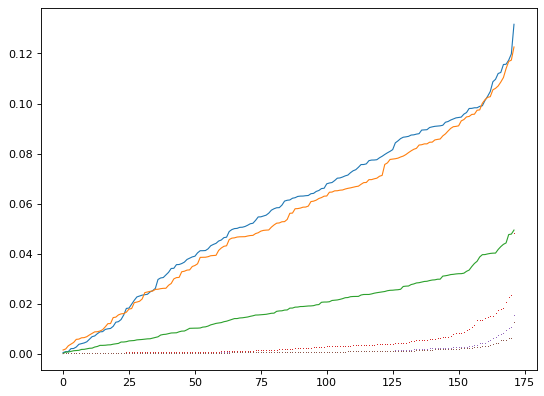

In [27]:
input_names = ['hRideF', 'hRideR', 'aRollAbs']
output_names = ['CLiftBodyF', 'CLiftBodyR', 'CDragBody']

fit_result = fit_aero_data(sample_data, input_names, output_names)

# Plot the sorted residuals.
plt.figure(figsize=(8, 6), dpi=80)
for r in fit_result.polynomial_residuals.T:
    plt.plot(sorted(abs(r)), '-', lw=1)
for e in fit_result.polynomial_rbf_residuals.T:
    plt.plot(sorted(abs(e)), ',', lw=1)
plt.show()

## Create the car component

In [28]:
aero_component = get_fit_as_component(
    fit_result,
    input_names,
    output_names)

print(json.dumps(aero_component, cls=NumpyEncoder, indent=2))

{
  "PolynomialCLiftBodyFDefinition": [
    {
      "expression": "hRideF * hRideF * hRideF",
      "coefficient": -7142.388322842246
    },
    {
      "expression": "hRideR * hRideR * hRideR",
      "coefficient": -223.4577245069057
    },
    {
      "expression": "aRollAbs * aRollAbs * aRollAbs",
      "coefficient": -96253.25144946738
    },
    {
      "expression": "hRideF * hRideF",
      "coefficient": -30.736142637757276
    },
    {
      "expression": "hRideR * hRideR",
      "coefficient": 70.9188462791816
    },
    {
      "expression": "aRollAbs * aRollAbs",
      "coefficient": 2396.6772796510586
    },
    {
      "expression": "hRideF * hRideR",
      "coefficient": -36.39292698299522
    },
    {
      "expression": "hRideF * aRollAbs",
      "coefficient": -174.9981702557531
    },
    {
      "expression": "hRideR * aRollAbs",
      "coefficient": -74.2573544192138
    },
    {
      "expression": "hRideF",
      "coefficient": -7.51511114391402
    },
    {
     

## Save a new car to the platform

For this example we'll load the `Canopy F1 Car 2019` and merge in the new aero data before saving it as a new car.

In [29]:
async with create_session() as session:
    input_car = await canopy.load_default_config(
        session,
        'car',
        'Canopy F1 Car 2019')
    
    input_car.data.aero = {**input_car.data.aero, **aero_component}

    new_config_id = await canopy.create_config(
        session,
        'car',
        'Canopy F1 Car 2019 with Fitted Aero',
        input_car.data)
    
new_config_id

'1eddc891e331414698ceb32d29084a48'